In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
import time
import copy
#disclaimer!
#większość kodu jest własnością profesora Przemysława Klęska,
#moim zadaniem było zrozumieć sposób działania kodu i wprowadzić algorytmy
#adam rms_prop, sgd_momentum i wykonać badania porównawcze
class MLPApproximator(BaseEstimator, RegressorMixin):

    ALGO_NAMES = ["sgd_simple", "sgd_momentum", "rmsprop", "adam"]

    def __init__(self, structure=[16, 8, 4], activation_name="relu", targets_activation_name="linear", initialization_name="uniform",
                 algo_name="sgd_simple", learning_rate=1e-2,  n_epochs=100, batch_size=10, seed=0,
                 verbosity_e=100, verbosity_b=10):
        self.structure = structure
        self.activation_name = activation_name
        self.targets_activation_name = targets_activation_name
        self.initialization_name = initialization_name
        self.algo_name = algo_name
        if self.algo_name not in self.ALGO_NAMES:
            self.algo_name = self.ALGO_NAMES[0]
        self.loss_name = "squared_loss"
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.seed = seed
        self.verbosity_e = verbosity_e
        self.verbosity_b = verbosity_b
        self.history_weights = {}
        self.history_weights0 = {}
        self.n_params = None
        # params / constants for algorithms
        self.momentum_beta = 0.9
        self.rmsprop_beta = 0.9
        self.rmsprop_epsilon = 1e-7
        self.adam_beta1 = 0.9
        self.adam_beta2 = 0.999
        self.adam_epsilon = 1e-7

    def __str__(self):
        txt = f"{self.__class__.__name__}(structure={self.structure},"
        txt += "\n" if len(self.structure) > 32 else " "
        txt += f"activation_name={self.activation_name}, targets_activation_name={self.targets_activation_name}, initialization_name={self.initialization_name}, "
        txt += f"algo_name={self.algo_name}, learning_rate={self.learning_rate}, n_epochs={self.n_epochs}, batch_size={self.batch_size})"
        if self.n_params:
            txt += f" [n_params: {self.n_params}]"
        return txt

    @staticmethod
    def he_uniform(n_in, n_out):
        scaler = np.sqrt(6.0 / n_in)
        return ((np.random.rand(n_out, n_in)  * 2.0 - 1.0) * scaler).astype(np.float32)

    @staticmethod
    def he_normal(n_in, n_out):
        scaler = np.sqrt(2.0 / n_in)
        return (np.random.randn(n_out, n_in) * scaler).astype(np.float32)

    @staticmethod
    def glorot_uniform(n_in, n_out):
        scaler = np.sqrt(6.0 / (n_in + n_out))
        return ((np.random.rand(n_out, n_in)  * 2.0 - 1.0) * scaler).astype(np.float32)

    @staticmethod
    def glorot_normal(n_in, n_out):
        scaler = np.sqrt(2.0 / (n_in + n_out))
        return (np.random.randn(n_out, n_in) * scaler).astype(np.float32)

    @staticmethod
    def prepare_batch_ranges(m, batch_size):
        n_batches = int(np.ceil(m / batch_size))
        batch_ranges = batch_size * np.ones(n_batches, dtype=np.int32)
        remainder = m % batch_size
        if remainder > 0:
            batch_ranges[-1] = remainder
        batch_ranges = np.r_[0, np.cumsum(batch_ranges)]
        return n_batches, batch_ranges

    @staticmethod
    def sigmoid(S):
        return 1.0 / (1.0 + np.exp(-S))

    @staticmethod
    def sigmoid_d(phi_S):
        return phi_S * (1.0 - phi_S)

    @staticmethod
    def relu(S):
        return np.clip(S, 0, 1e10)

    @staticmethod
    def relu_d(phi_S):
        return (phi_S > 0.0).astype(np.float32)

    @staticmethod
    def linear(S):
        return S

    @staticmethod
    def linear_d(phi_S):
        return np.ones(phi_S.shape, dtype=np.float32)

    @staticmethod
    def squared_loss(y_MLP, y_target):
        return np.clip((y_MLP - y_target)**2, -1e10, 1e10)

    @staticmethod
    def squared_loss_d(y_MLP, y_target):
        return np.clip(2.0 * (y_MLP - y_target), -1e10, 1e10)

    def pre_algo_sgd_simple(self):
        return # no special preparation needed for simple SGD

    def algo_sgd_simple(self, l):
        self.weights_[l] = self.weights_[l] - self.learning_rate * self.gradients[l]
        self.weights0_[l] = self.weights0_[l] - self.learning_rate * self.gradients0[l]
         # TODO: self.weights_[l], self.weights0_[l] to be updated (l is a layer index)

    def pre_algo_sgd_momentum(self):
        self.mt_ = [np.zeros_like(weight) for weight in self.weights_]
        self.mt0_ = [np.zeros_like(weight) for weight in self.weights0_]
    def algo_sgd_momentum(self, l):
        # TODO: self.weights_[l], self.weights0_[l] to be updated (l is a layer index)
        self.mt_[l] = self.momentum_beta * self.mt_[l] + (1 - self.momentum_beta) * self.gradients[l]
        self.mt0_[l] = self.momentum_beta * self.mt0_[l] + (1 - self.momentum_beta) * self.gradients0[l]
        self.weights_[l] = self.weights_[l] - self.learning_rate * self.mt_[l]
        self.weights0_[l] = self.weights0_[l] - self.learning_rate * self.mt0_[l]

    def pre_algo_rmsprop(self):
        self.v_ = [np.zeros_like(weight) for weight in self.weights_]
        self.v0_ = [np.zeros_like(weight) for weight in self.weights0_]

    def algo_rmsprop(self, l):
        self.v_[l] = self.rmsprop_beta * self.v_[l] + (1 - self.rmsprop_beta) * np.power(self.gradients[l], 2)
        self.v0_[l] = self.rmsprop_beta * self.v0_[l] + (1 - self.rmsprop_beta) * np.power(self.gradients0[l], 2)

        self.weights_[l] = self.weights_[l] - (self.learning_rate/(np.sqrt(self.v_[l] + self.rmsprop_epsilon))) * self.gradients[l]
        self.weights0_[l] = self.weights0_[l] - (self.learning_rate/(np.sqrt(self.v0_[l] + self.rmsprop_epsilon))) * self.gradients0[l]
    def pre_algo_adam(self):
        self.mt_ = [np.zeros_like(weight) for weight in self.weights_]
        self.mt0_ = [np.zeros_like(weight) for weight in self.weights0_]

        self.v_ = [np.zeros_like(weight) for weight in self.weights_]
        self.v0_ = [np.zeros_like(weight) for weight in self.weights0_]
        self.t_ = 0

    def algo_adam(self, l):
        self.t_ += 1 #KORZYSTAJ Z .t co już jest w epokach, to jest trochę błędne
        self.mt_[l] = self.adam_beta1 * self.mt_[l] + (1 - self.adam_beta1) * self.gradients[l]
        self.mt0_[l] = self.adam_beta1 * self.mt0_[l] + (1 - self.adam_beta1) * self.gradients0[l]

        self.v_[l] = self.adam_beta2 * self.v_[l] + (1 - self.adam_beta2) * np.power(self.gradients[l], 2)
        self.v0_[l] = self.adam_beta2 * self.v0_[l] + (1 - self.adam_beta2) * np.power(self.gradients0[l], 2)

        self.mt_proper = self.mt_[l]/(1 - np.power(self.adam_beta1, self.t_))
        self.mt0_proper = self.mt0_[l]/(1 - np.power(self.adam_beta1, self.t_))

        self.v_proper = self.v_[l]/(1 - np.power(self.adam_beta2, self.t_))
        self.v0_proper = self.v0_[l]/(1 - np.power(self.adam_beta2, self.t_))

        self.weights_[l] = self.weights_[l] - self.learning_rate * self.mt_proper/(np.sqrt(self.v_proper) + self.adam_epsilon)
        self.weights0_[l] = self.weights0_[l] - self.learning_rate * self.mt0_proper/(np.sqrt(self.v0_proper) + self.adam_epsilon)

    def fit(self, X, y):
        np.random.seed(self.seed)
        self.activation_ = getattr(MLPApproximator, self.activation_name)
        self.activation_d_ = getattr(MLPApproximator, self.activation_name + "_d")
        self.initialization_ = getattr(MLPApproximator, ("he_" if self.activation_name == "relu" else "glorot_") + self.initialization_name)
        self.targets_activation_ = getattr(MLPApproximator, self.targets_activation_name)
        self.targets_activation_d_ = getattr(MLPApproximator, self.targets_activation_name + "_d")
        self.loss_ = getattr(MLPApproximator, self.loss_name)
        self.loss_d_ = getattr(MLPApproximator, self.loss_name + "_d")
        self.pre_algo_ = getattr(self, "pre_algo_" + self.algo_name)
        self.algo_ = getattr(self, "algo_" + self.algo_name)
        self.weights_ = [None] # so that network inputs are considered layer 0, and actual layers of neurons are numbered 1, 2, ...
        self.weights0_ = [None] # so that network inputs are considered layer 0, and actual layers of neurons are numbered 1, 2, ...
        m, n = X.shape
        if len(y.shape) == 1:
            y = np.array([y]).T
        self.n_ = n
        self.n_targets_ = 1 if len(y.shape) == 1 else y.shape[1]
        self.n_params = 0
        for l in range(len(self.structure) + 1):
            n_in = n if l == 0 else self.structure[l - 1]
            n_out = self.structure[l] if l < len(self.structure) else self.n_targets_
            w = self.initialization_(n_in, n_out)
            w0 = np.zeros((n_out, 1), dtype=np.float32)
            self.weights_.append(w)
            self.weights0_.append(w0)
            self.n_params += w.size
            self.n_params += w0.size
        t1 = time.time()
        if self.verbosity_e > 0:
            print(f"FIT [total of weights (params): {self.n_params}]")
        self.pre_algo_() # if some preparation needed
        n_batches, batch_ranges = MLPApproximator.prepare_batch_ranges(m, self.batch_size)
        self.t = 0
        for e in range(self.n_epochs):
            t1_e = time.time()
            if e % self.verbosity_e == 0 or e == self.n_epochs - 1:
                print("-" * 3)
                print(f"EPOCH {e + 1}/{self.n_epochs}:")
                self.forward(X)
                loss_e_before = np.mean(self.loss_(self.signals[-1], y))
            p = np.random.permutation(m)
            for b in range(n_batches):
                indexes = p[batch_ranges[b] : batch_ranges[b + 1]]
                X_b = X[indexes]
                y_b = y[indexes]
                self.forward(X_b)
                loss_b_before = np.mean(self.loss_(self.signals[-1], y_b))
                self.backward(y_b)
                for l in range(1, len(self.structure) + 2):
                    self.algo_(l)
                if (e % self.verbosity_e == 0 or e == self.n_epochs - 1) and b % self.verbosity_b == 0:
                    self.forward(X_b)
                    loss_b_after = np.mean(self.loss_(self.signals[-1], y_b))
                    print(f"[epoch {e + 1}/{self.n_epochs}, batch {b + 1}/{n_batches} -> loss before: {loss_b_before}, loss after: {loss_b_after}]")
                self.t += 1
            t2_e = time.time()
            if e % self.verbosity_e == 0 or e == self.n_epochs - 1:
                self.forward(X)
                loss_e_after = np.mean(self.loss_(self.signals[-1], y))
                self.history_weights[e] = copy.deepcopy(self.weights_)
                self.history_weights0[e] = copy.deepcopy(self.weights0_)
                print(f"ENDING EPOCH {e + 1}/{self.n_epochs} [loss before: {loss_e_before}, loss after: {loss_e_after}; epoch time: {t2_e - t1_e} s]")
        t2 = time.time()
        if self.verbosity_e > 0:
            print(f"FIT DONE. [time: {t2 - t1} s]")

    def forward(self, X_b):
        self.signals = [None] * (len(self.structure) + 2)
        self.signals[0] = X_b
        for l in range(1, len(self.structure) + 2):
            S_l = (self.weights_[l].dot(self.signals[l - 1].T) + self.weights0_[l]).T
            activation = self.activation_ if l <= len(self.structure) else self.targets_activation_
            phi_S_l = activation(S_l)
            self.signals[l] = phi_S_l

    def backward(self, y_b):
        self.deltas = [None] * len(self.signals)
        self.gradients = [None] * len(self.signals)
        self.gradients0 = [None] * len(self.signals)
        y_MLP = self.signals[-1]
        self.deltas[-1] = self.targets_activation_d_(y_MLP) * self.loss_d_(y_MLP, y_b)
        b = y_b.shape[0] #nasz wsad
        clip_value = 1e3
        for l in range(len(self.structure) + 1, 0, -1):
            X_l = self.signals[l - 1]
            if l > 1:
                self.deltas[l - 1] = self.activation_d_(X_l) * np.clip(self.deltas[l].dot(self.weights_[l]), -clip_value, clip_value)
            self.gradients[l] = np.clip(self.deltas[l].T.dot(X_l), -clip_value, clip_value)
            self.gradients0[l] = np.clip(self.deltas[l].T.dot(np.ones((b, 1), dtype=np.float32)), -clip_value, clip_value)

    def predict(self, X):
        self.forward(X)
        y_pred = self.signals[-1]
        if self.n_targets_ == 1:
            y_pred = y_pred[:, 0]
        return y_pred

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle as pkl

def fake_data(m, domain=np.pi, noise_std=0.1):
    np.random.seed(0)
    X = np.random.rand(m, 2) * domain
    y = np.cos(X[:, 0] * X[:, 1]) * np.cos(2 * X[:, 0]) + np.random.randn(m) * noise_std # target: cos(x_1 * x_2) * cos(2 * x_1) + normal noise
    return X, y

def loss_during_fit(approx, X_train, y_train, X_test, y_test):
    keys = list(approx.history_weights.keys())
    epochs = []
    losses_train = []
    losses_test = []
    weights = approx.weights_
    weights0 = approx.weights0_
    for k in keys:
        epochs.append(k + 1)
        approx.weights_ = approx.history_weights[k]
        approx.weights0_ = approx.history_weights0[k]
        losses_train.append(np.mean((approx.predict(X_train) - y_train)**2))
        losses_test.append(np.mean((approx.predict(X_test) - y_test)**2))
    approx.weights_ = weights
    approx.weights0_ = weights0
    return epochs, losses_train, losses_test

def r2_during_fit(approx, X_train, y_train, X_test, y_test):
    keys = list(approx.history_weights.keys())
    epochs = []
    r2s_train = []
    r2s_test = []
    weights = approx.weights_
    weights0 = approx.weights0_
    for k in keys:
        epochs.append(k + 1)
        approx.weights_ = approx.history_weights[k]
        approx.weights0_ = approx.history_weights0[k]
        r2s_train.append(approx.score(X_train, y_train))
        r2s_test.append(approx.score(X_test, y_test))
    approx.weights_ = weights
    approx.weights0_ = weights0
    return epochs, r2s_train, r2s_test

if __name__ == '__main__':
    print("MLP DEMO...")

    # DATA
    domain = 1.5 * np.pi
    noise_std = 0.1
    m_train = 1000
    m_test = 10000

    ALGO_NAMES = ["sgd_simple", "sgd_momentum", "rmsprop", "adam"]
    LEARNING_RATES = [1e-2, 1e-3, 1e-4]
    ACTIVATION_FUNCTIONS = ["sigmoid", "relu"]

    # nie chciało działać z inicjalizacją w liście
    third_layer = [64] * 5 + [32] * 5 + [16] * 5 + [8] * 5
    LAYERS = [[128, 64, 32],[128, 128, 64, 64, 32, 32], third_layer]


    data_settings_str = f"{domain=}, {noise_std=}, {m_train=}, {m_test=}"
    print(f"DATA SETTINGS: {data_settings_str}")
    X_train, y_train = fake_data(m_train, domain, noise_std)
    X_test, y_test= fake_data(m_test, domain, noise_std)

    # APPROXIMATOR (NEURAL NETWORK)
    for name in ALGO_NAMES:
      for rate in LEARNING_RATES:
        for function in ACTIVATION_FUNCTIONS:
          for layer in LAYERS:
              approx = MLPApproximator(structure=LAYERS[1], activation_name="relu", targets_activation_name="linear", initialization_name="uniform",
                                      algo_name="sgd_simple", learning_rate=1e-2,
                                      n_epochs=1000, batch_size=10, seed=49261,
                                      verbosity_e=100, verbosity_b=10)
              print(f"APPROXIMATOR (NEURAL NETWORK): {approx}")

              # FIT
              approx.fit(X_train, y_train)

              # METRICS - LOSS, R^2
              y_pred = approx.predict(X_train)
              mse = np.mean((y_pred - y_train)**2)
              print(f"LOSS TRAIN (MSE): {mse}")
              y_pred_test = approx.predict(X_test)
              mse_test = np.mean((y_pred_test - y_test)**2)
              print(f"LOSS TEST (MSE): {mse_test}")
              print(f"R^2 TRAIN: {approx.score(X_train, y_train)}")
              print(f"R^2 TEST: {approx.score(X_test, y_test)}")
              print("MLP DEMO DONE.")

              # PLOTS
              mesh_size = 50
              X1, X2 = np.meshgrid(np.linspace(0.0, domain, mesh_size), np.linspace(0.0, domain, mesh_size))
              X12 = np.array([X1.ravel(), X2.ravel()]).T
              y_ref = np.cos(X12[:, 0] * X12[:, 1]) * np.cos(2 * X12[:, 0])
              Y_ref = np.reshape(y_ref, (mesh_size, mesh_size))
              y_pred = approx.predict(X12)
              Y_pred = np.reshape(y_pred, (mesh_size, mesh_size))
              epochs, losses_train, losses_test = loss_during_fit(approx, X_train, y_train, X_test, y_test)
              epochs, r2s_train, r2s_test = r2_during_fit(approx, X_train, y_train, X_test, y_test)
              fig = plt.figure(figsize=(16, 9))
              fig.suptitle(f"DATA SETTINGS: {data_settings_str}\nAPPROXIMATOR (NEURAL NETWORK): {approx}", fontsize=8)
              ax_loss = fig.add_subplot(2, 2, 1)
              ax_loss.set_title("TRAIN / TEST LOSS DURING FIT (MSE - MEAN SQUARED ERROR)")
              ax_loss.plot(epochs, losses_train, color="blue", marker=".", label="LOSS ON TRAIN DATA")
              ax_loss.plot(epochs, losses_test, color="red", marker=".", label="LOSS ON TEST DATA")
              ax_loss.legend()
              ax_loss.grid(color="gray", zorder=0, dashes=(4.0, 4.0))
              ax_loss.set_xlabel("EPOCH")
              ax_loss.set_ylabel("SQUARED LOSS")
              ax_r2 = fig.add_subplot(2, 2, 2)
              ax_r2.set_title("TRAIN / TEST $R^2$ DURING FIT (COEF. OF DETERMINATION)")
              ax_r2.plot(epochs, r2s_train, color="blue", marker=".", label="$R^2$ ON TRAIN DATA")
              ax_r2.plot(epochs, r2s_test, color="red", marker=".", label="$R^2$ ON TEST DATA")
              ax_r2.set_ylim(-0.25, 1.05)
              ax_r2.legend()
              ax_r2.grid(color="gray", zorder=0, dashes=(4.0, 4.0))
              ax_r2.set_xlabel("EPOCH")
              ax_r2.set_ylabel("$R^2$")
              ax_train_data = fig.add_subplot(2, 3, 4, projection='3d')
              ax_target = fig.add_subplot(2, 3, 5, projection='3d')
              ax_approximator = fig.add_subplot(2, 3, 6, projection='3d')
              ax_train_data.set_title("TRAINING DATA", pad=-32)
              ax_train_data.scatter(X_train[:, 0], X_train[:, 1], y_train, marker=".")
              ax_target.set_title("TARGET (TO BE APPROXIMATED)", pad=-128)
              ax_target.plot_surface(X1, X2, Y_ref, cmap=cm.get_cmap("Spectral"))
              ax_approximator.set_title("NEURAL APPROXIMATOR")
              ax_approximator.plot_surface(X1, X2, Y_pred, cmap=cm.get_cmap("Spectral"))
              ax_train_data.set_box_aspect([2, 2, 1])
              ax_target.set_box_aspect([2, 2, 1])
              ax_approximator.set_box_aspect([2, 2, 1])
              plt.subplots_adjust(top=0.9, bottom=0.05, left=0.1, right=0.9, hspace=0.25, wspace=0.15)
              plt.show()

              pkl.dump(  fig,  open('FigureObject.pickle',  'wb')  )

MLP DEMO...
DATA SETTINGS: domain=4.71238898038469, noise_std=0.1, m_train=1000, m_test=10000


NameError: name 'MLPApproximator' is not defined

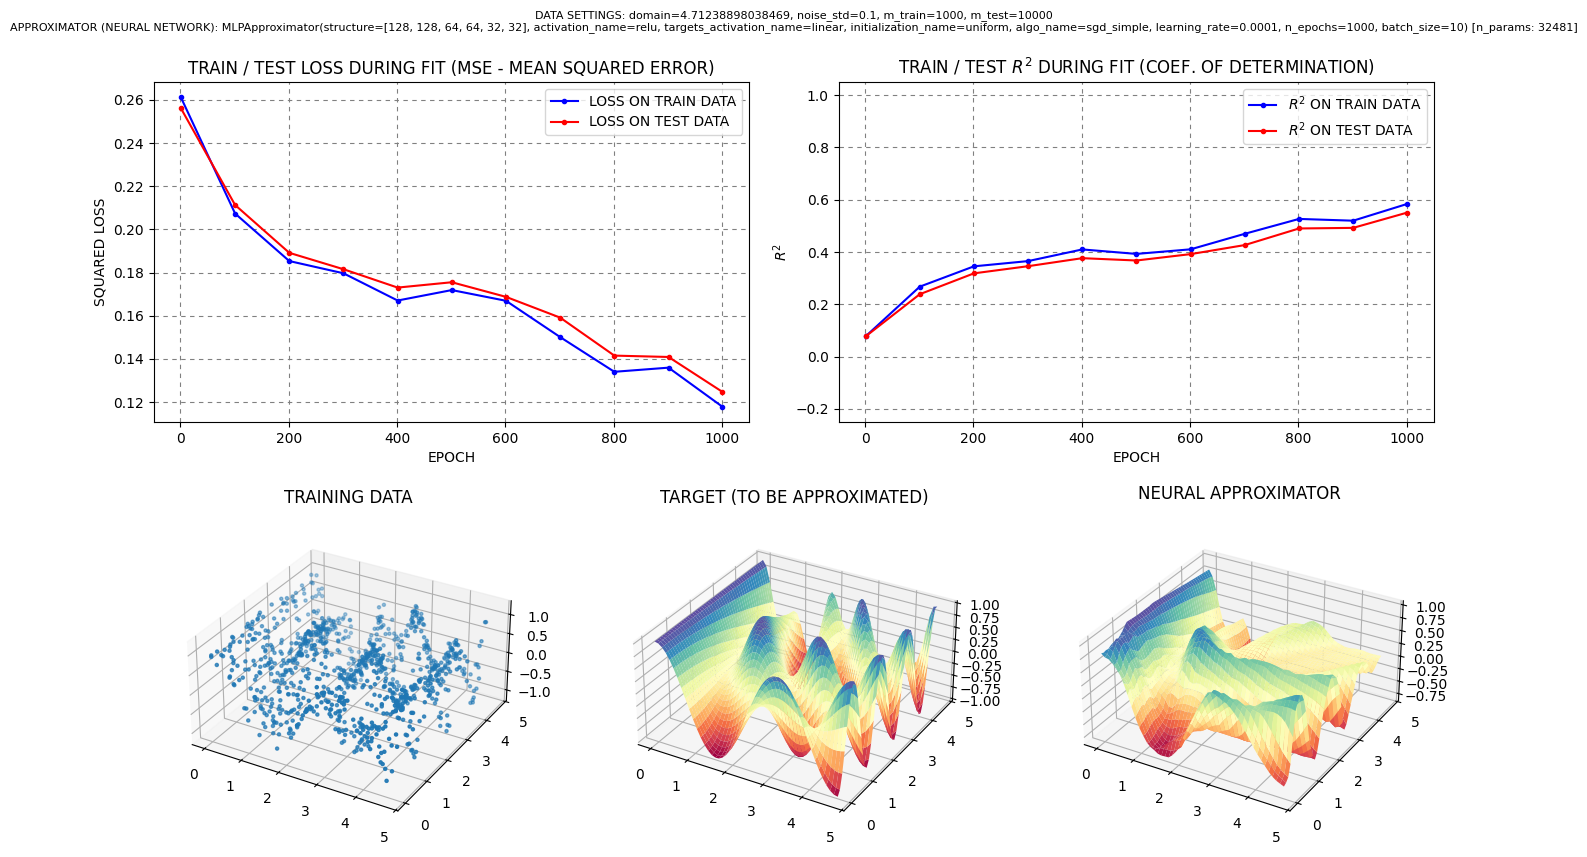

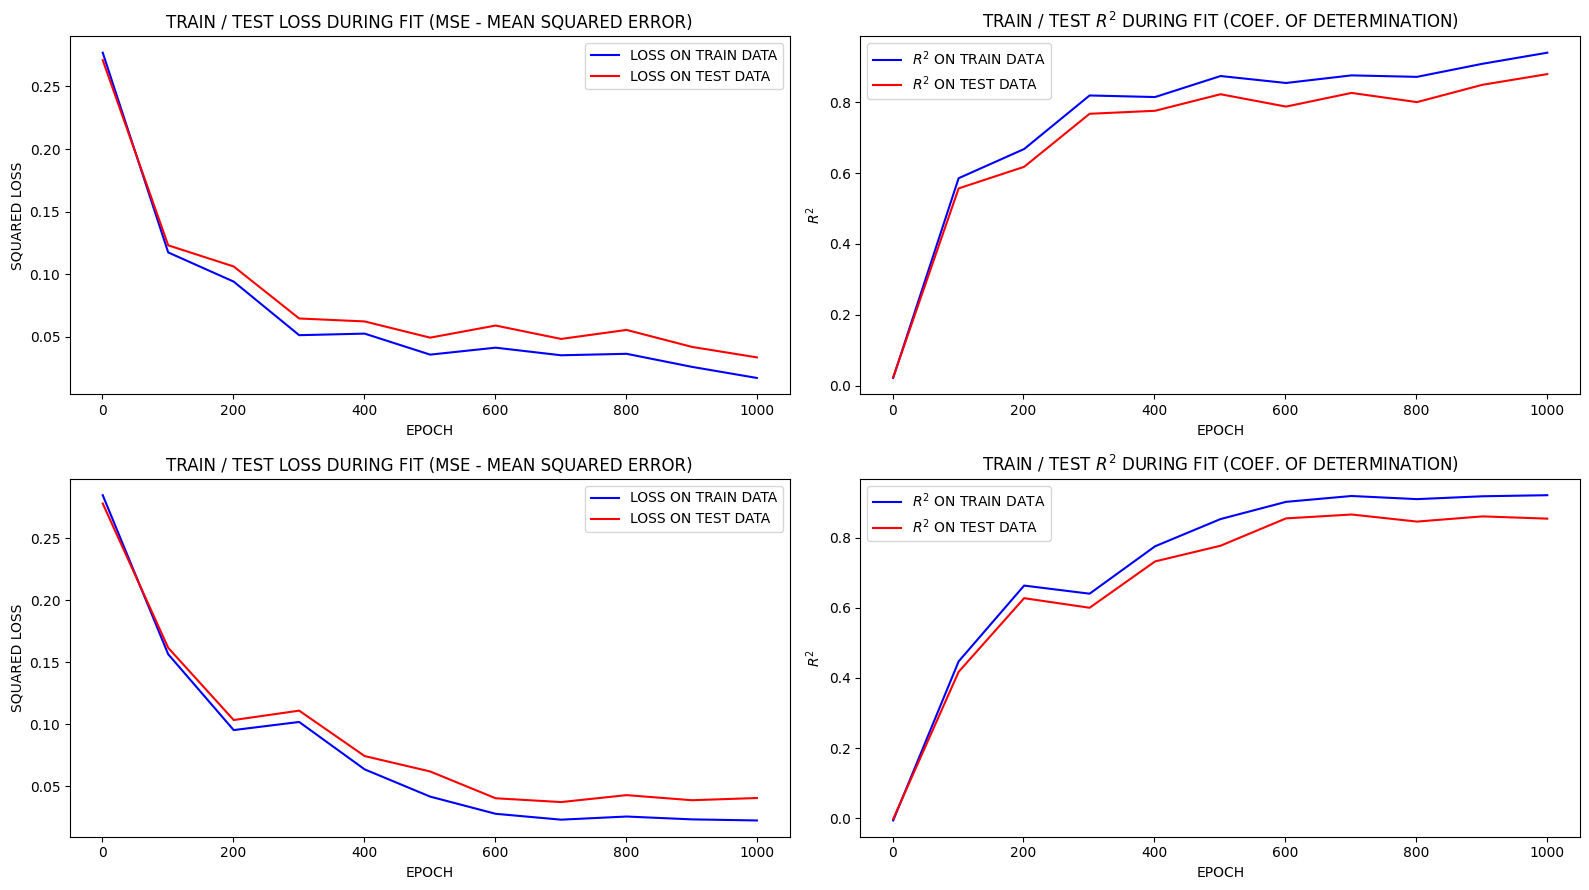

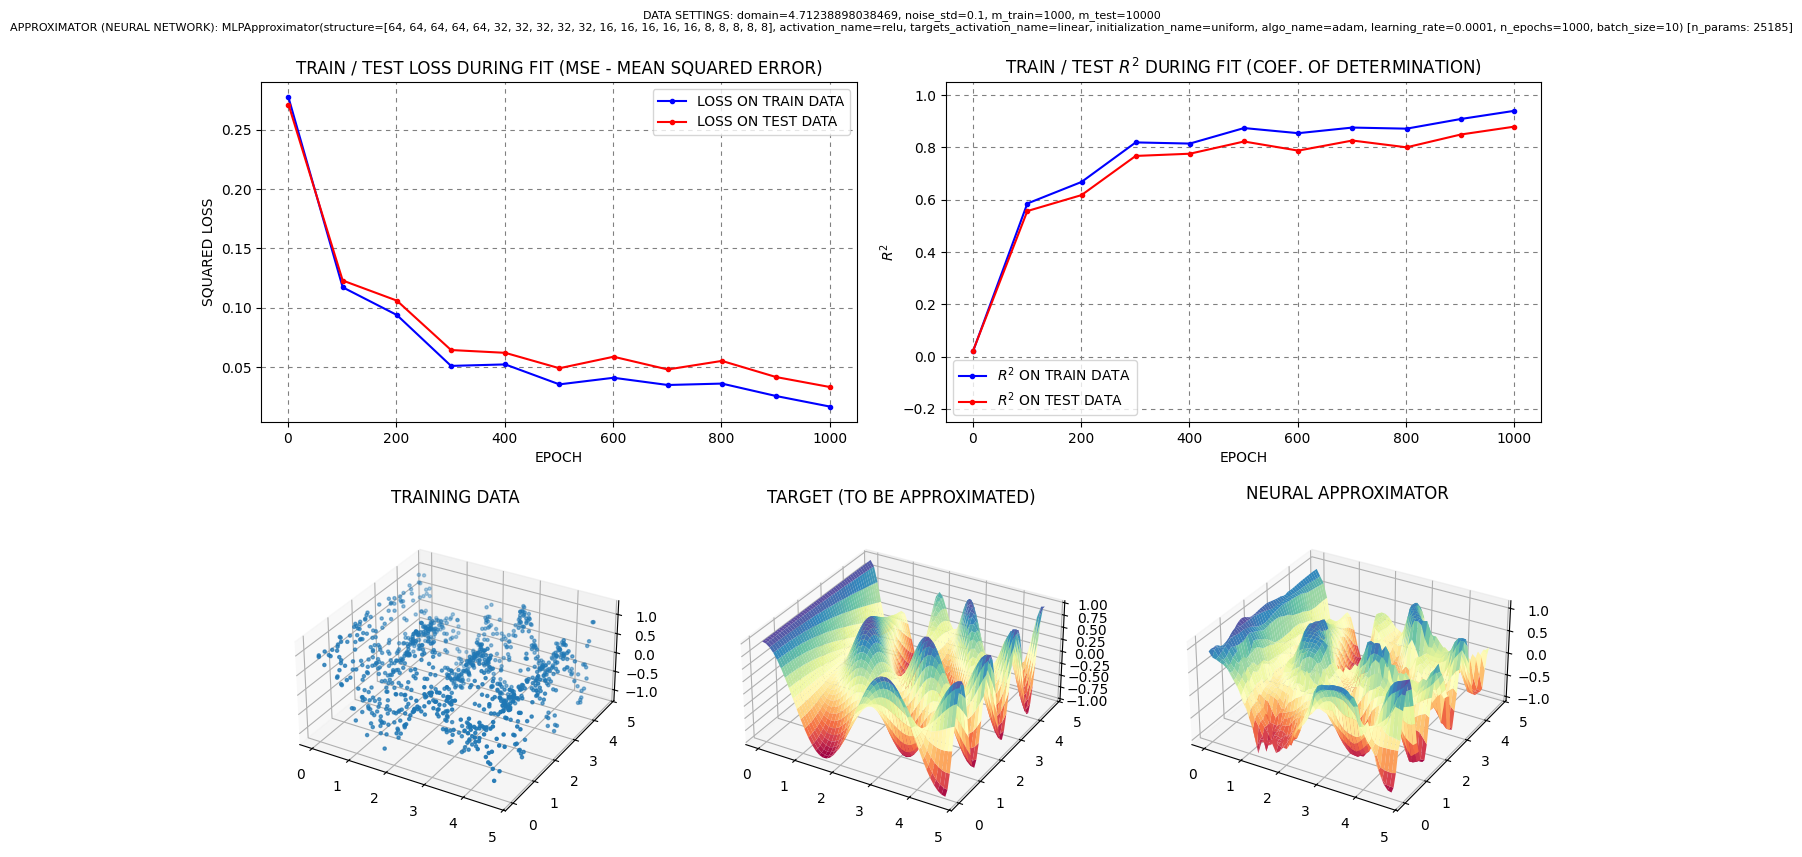

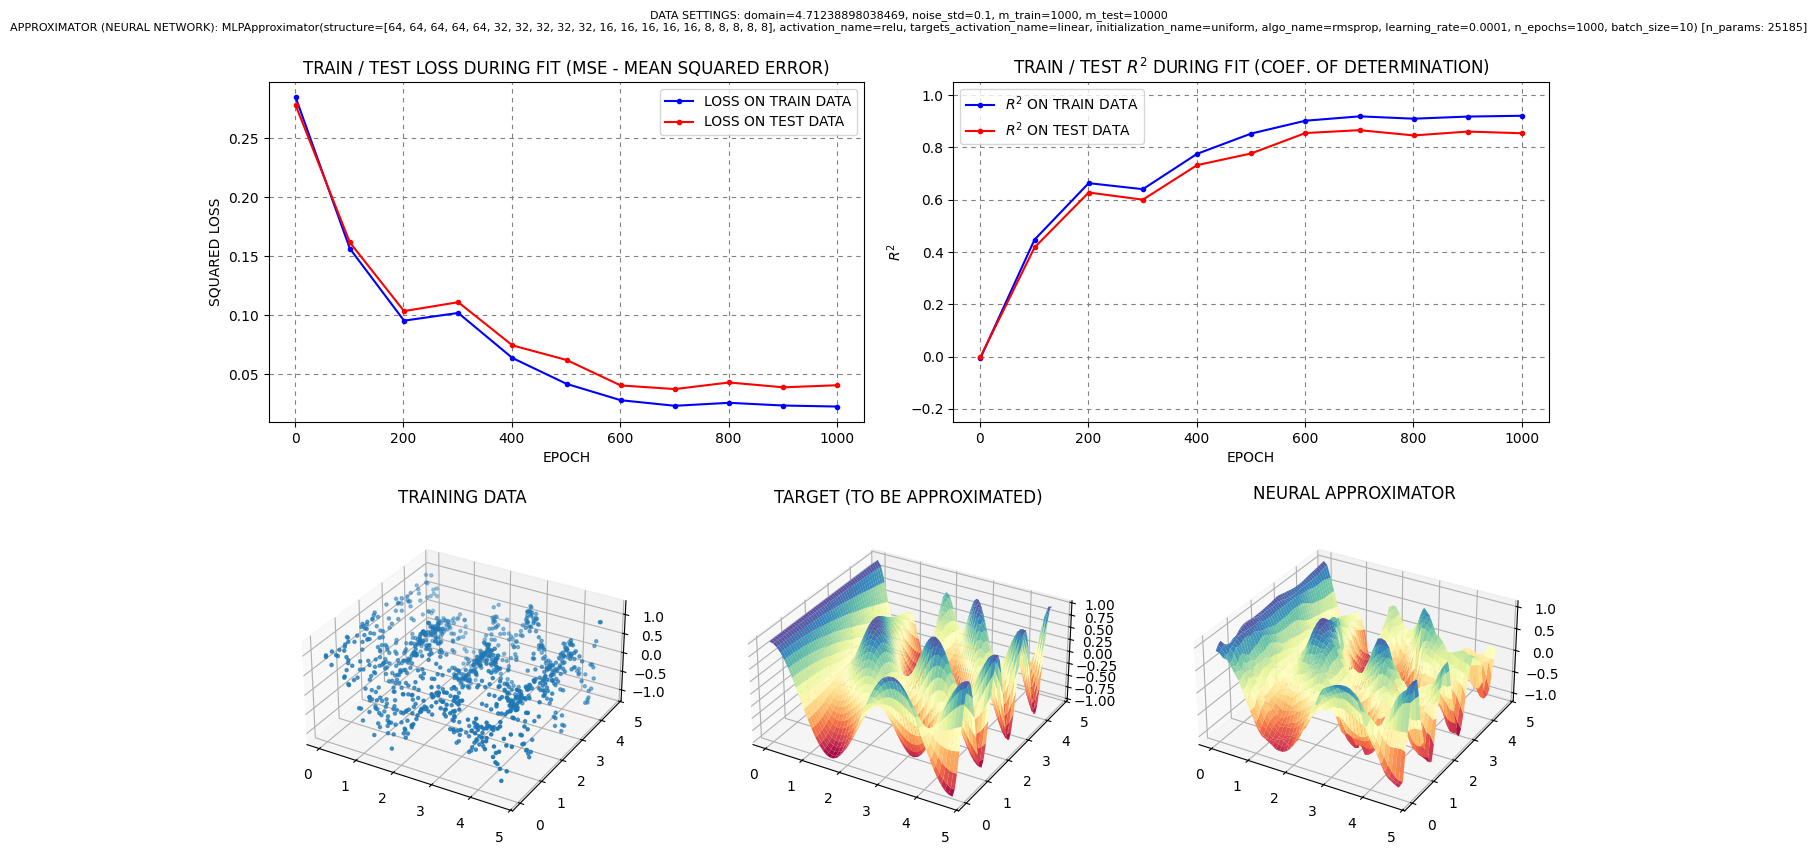

In [ ]:
import pickle
import matplotlib.pyplot as plt

def make_manager(fig):
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

def plot_comparison(filenames):
    rows = len(filenames)
    new_fig, new_axes = plt.subplots(rows, 2, figsize=(16, 9))

    for idx, filename in enumerate(filenames):
        with open(filename, 'rb') as file:
            fig = pickle.load(file)

        axes = fig.get_axes()
        selected_axes = [axes[0], axes[1]]  # dwa pierwsze wykresy są nam potrzebne

        #przechodzimy przez wykresy i kopiujemy dane
        for j, orig_ax in enumerate(selected_axes):
            new_ax = new_axes[idx, j]
            for line in orig_ax.get_lines():
                xdata, ydata = line.get_xdata(), line.get_ydata()
                new_ax.plot(xdata, ydata, label=line.get_label(), color=line.get_color())

            # Kopiowanie tytułów, etykiet, legendy
            new_ax.set_title(orig_ax.get_title())
            new_ax.set_xlabel(orig_ax.get_xlabel())
            new_ax.set_ylabel(orig_ax.get_ylabel())
            if orig_ax.get_legend():
                new_ax.legend()

        # Zamykamy oryginalną figurę
        plt.close(fig)

    plt.tight_layout()  # Dopasowanie układu
    plt.show()

with open('/content/[128, 128, 64, 64, 32, 32]_relu_sgd_simple_0.0001_pkl', 'rb') as file:
    fig = pickle.load(file)

make_manager(fig)



filenames = ['/content/[64, 64, 64, 64, 64, 32, 32, 32, 32, 32, 16, 16, 16, 16, 16, 8, 8, 8, 8, 8]_relu_adam_0.0001_pkl', '/content/[64, 64, 64, 64, 64, 32, 32, 32, 32, 32, 16, 16, 16, 16, 16, 8, 8, 8, 8, 8]_relu_rmsprop_0.0001_pkl' ]
plot_comparison(filenames)
for filename in filenames:
  with open(filename, 'rb') as file:
    fig = pickle.load(file)
    make_manager(fig)

